In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

In [15]:
TOPICS = ["Astronomy", "Health", "Economy"]
TOPICS_MAP = {"Astronomy": 0, "Health": 1, "Economy": 2}

In [16]:
def create_dataset(topics):
    data = {'hash':[],'topic': [], 'text': []}
    for topic in topics:
        for file in os.listdir(f"Documents/{topic}"):
            with open(f"Documents/{topic}/{file}", "r", encoding="utf-8") as f:
                text = f.read()
                data['hash'].append(file)
                data['topic'].append(topic)
                data['text'].append(text)
    return pd.DataFrame(data)

data = create_dataset(TOPICS)
data

,hash,topic,text
0,070c9fd24e43ba164f3a68dd8c976a57461fceb038a43d...,Astronomy,cosmic countdown begun director james gunn ’ `...
1,09559783f5ee1852885289ba8fd16625284625dd41875e...,Astronomy,planetary society taking stand nasa 's stalled...
2,09d01585d21facc6f893ec9c64a6d79ffc107be243f10d...,Astronomy,may helpful receive news updates notifications...
3,0a3d8dfb0821ff1ed7ad6fd00ad318c667f9300b37ea71...,Astronomy,spacex falcon 9 rocket used first stage launch...
4,111ab5bb8e4daf91448b849d23e91da843ff026e4803b1...,Astronomy,son 's 40-year-old sketch astronaut dad 's mis...
...,...,...,...
190,e2603ae7220618cf35de8713015bf5d225d0cb97765e0b...,Economy,amazon-owned audible started putting ads audio...
191,e502123029685fc536e71460d80a5a430d94062a51ab90...,Economy,tuesday 's budget included new money create na...
192,e558e08d8462e014b1e55f2e08f8a16f9f4d891b74c031...,Economy,raymond james says collected responses 48 cana...
193,e9cdffafbe7284b1a428ec912e065ba17127264fa1737b...,Economy,surge stock could driven idea indictment bad n...


In [17]:
def preprocess(data,topics_map):
    tokenizer = RegexpTokenizer(r'\w+')
    data['text'] = data['text'].apply(lambda x: tokenizer.tokenize(x.lower()))
    data['text'] = data['text'].apply(lambda x: ' '.join(x))
    data['label'] = data['topic'].map(topics_map)
    X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess(data,TOPICS_MAP)
X_train

26     purchase links site may earn affiliate commiss...
139    nikkei 225cad eurdeadly storm whips tornadoes ...
143    ukraine latest russia said formally charge wsj...
71     hearing lots achoos little one grown ups ones ...
8      purchase links site may earn affiliate commiss...
                             ...                        
103    approach content integrityhealthline prioritiz...
67     depression testquiz replace clinical diagnosis...
117    kidney stone small hard substance made waste p...
47     next full moon thursday april 6 12 34 a m edt ...
172    blackrock sell 114 billion failed banks securi...
Name: text, Length: 156, dtype: object

In [18]:
def create_tf_idf(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf
X_train_tfidf, X_test_tfidf = create_tf_idf(X_train,X_test)
X_train_tfidf

<156x16317 sparse matrix of type '<class 'numpy.float64'>'
	with 61595 stored elements in Compressed Sparse Row format>

In [19]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score,average='macro'),
           'recall': make_scorer(recall_score, average='macro'),
           'f1_score': make_scorer(f1_score, average='macro')}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

In [20]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test, plot=False):
    print("Test Metrics")
    y_pred = model.predict(X_test_tfidf)
    #Test to see if predict_proba works
    _ = model.predict_proba(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    if plot:
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
        plt.show()
    return report

Model: SVC
Fold: 1
Accuracy: 0.96875
Precision: 0.9722222222222222
Recall: 0.9666666666666667
F1 Score: 0.9679633867276888


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 0.967741935483871
Precision: 0.9696969696969697
Recall: 0.9666666666666667
F1 Score: 0.9665831244778613


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 0.967741935483871
Precision: 0.9696969696969697
Recall: 0.9666666666666667
F1 Score: 0.9665831244778613


Mean Metrics
Mean Accuracy: 0.9808467741935484
Mean Precision: 0.9823232323232324
Mean Recall: 0.9800000000000001
Mean F1 Score: 0.9802259271366822
Best Estimator: 1
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.92      1.00      0.96        11
           2       1.00      0.93      0.96        14

    accuracy                           0.97        39
   macro avg       0.97      0.98     

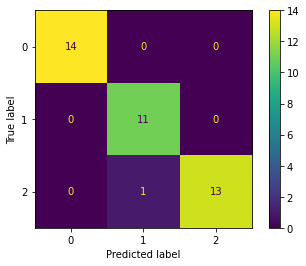



Model: KNeighborsClassifier
Fold: 1
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Mean Metrics
Mean Accuracy: 1.0
Mean Precision: 1.0
Mean Recall: 1.0
Mean F1 Score: 1.0
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        14

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39



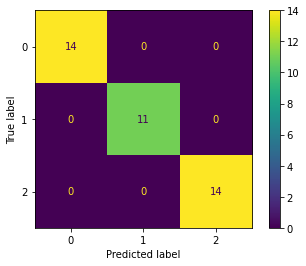



Model: DecisionTreeClassifier
Fold: 1
Accuracy: 0.96875
Precision: 0.9722222222222222
Recall: 0.9666666666666667
F1 Score: 0.9679633867276888


Fold: 2
Accuracy: 0.8709677419354839
Precision: 0.886039886039886
Recall: 0.8696969696969697
F1 Score: 0.8742690058479532


Fold: 3
Accuracy: 0.8064516129032258
Precision: 0.8092592592592592
Recall: 0.806060606060606
F1 Score: 0.8064836003051106


Fold: 4
Accuracy: 0.8064516129032258
Precision: 0.8037037037037038
Recall: 0.8121212121212121
F1 Score: 0.8030303030303031


Fold: 5
Accuracy: 0.8709677419354839
Precision: 0.8740740740740741
Recall: 0.8727272727272727
F1 Score: 0.8694463431305537


Mean Metrics
Mean Accuracy: 0.864717741935484
Mean Precision: 0.869059829059829
Mean Recall: 0.8654545454545455
Mean F1 Score: 0.8642385278083218
Best Estimator: 0
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.91      0.91      0.91        11
        

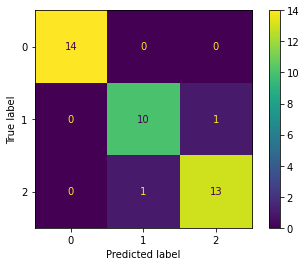



Model: LogisticRegression
Fold: 1
Accuracy: 0.96875
Precision: 0.9722222222222222
Recall: 0.9666666666666667
F1 Score: 0.9679633867276888


Fold: 2
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 3
Accuracy: 0.967741935483871
Precision: 0.9722222222222222
Recall: 0.9666666666666667
F1 Score: 0.9679633867276888


Fold: 4
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 5
Accuracy: 0.967741935483871
Precision: 0.9696969696969697
Recall: 0.9666666666666667
F1 Score: 0.9665831244778613


Mean Metrics
Mean Accuracy: 0.9808467741935484
Mean Precision: 0.9828282828282828
Mean Recall: 0.9800000000000001
Mean F1 Score: 0.9805019795866479
Best Estimator: 1
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        14

    accuracy                           1.00        39
   macro avg       1.

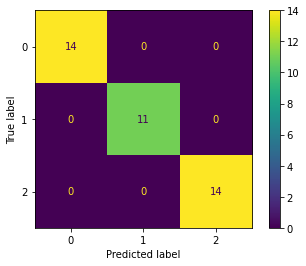



Model: GaussianNB
Fold: 1
Accuracy: 0.96875
Precision: 0.9722222222222222
Recall: 0.9666666666666667
F1 Score: 0.9679633867276888


Fold: 2
Accuracy: 0.9354838709677419
Precision: 0.9444444444444445
Recall: 0.9333333333333332
F1 Score: 0.9326599326599326


Fold: 3
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Fold: 4
Accuracy: 0.967741935483871
Precision: 0.9696969696969697
Recall: 0.9696969696969697
F1 Score: 0.9682539682539683


Fold: 5
Accuracy: 0.9032258064516129
Precision: 0.9074074074074074
Recall: 0.903030303030303
F1 Score: 0.9011923748765853


Mean Metrics
Mean Accuracy: 0.9550403225806452
Mean Precision: 0.9587542087542088
Mean Recall: 0.9545454545454545
Mean F1 Score: 0.954013932503635
Best Estimator: 2
[0 1 2]
Test Metrics
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       1.00      1.00      1.00        11
           2       0.93      0.93      0.93        14

    accuracy            

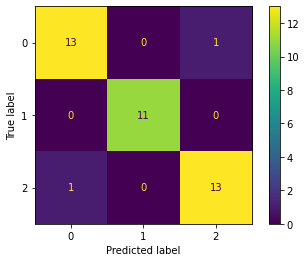

In [23]:
def train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test):
    models = [SVC(probability=True),KNeighborsClassifier(),DecisionTreeClassifier(),LogisticRegression(),GaussianNB()]
    reports = {}
    for model in models:
        print(f"Model: {model.__class__.__name__}")
        if model.__class__.__name__ == "GaussianNB":
            X_train_tfidf = X_train_tfidf.toarray()
            X_test_tfidf = X_test_tfidf.toarray()
        best_estimator = cross_validate_and_train(model,X_train_tfidf,y_train)
        print(best_estimator.classes_)
        report = test_model(best_estimator,X_test_tfidf,y_test,plot=True)
        reports[model.__class__.__name__] = [best_estimator,report]
        print("\n")
    return reports
reports = train_and_test_models(X_train_tfidf,y_train,X_test_tfidf,y_test)

In [24]:
def choose_best_model(reports):
    #Choose best model based on highest accuracy, precision, recall and f1 score
    best_model = None
    best_score = 0
    model_name = None
    for model in reports:
        report = reports[model][1]
        score = report['accuracy'] + report['macro avg']['precision'] + report['macro avg']['recall'] + report['macro avg']['f1-score']
        if score > best_score:
            best_score = score
            best_model = reports[model][0]
            model_name = model
    return model_name, best_model
model_name, best_model = choose_best_model(reports)
print(f"Best Model: {model_name}")

Best Model: KNeighborsClassifier


In [25]:
probs = best_model.predict_proba(X_test_tfidf)
for prob in probs:
    print(prob)

[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0.8 0.  0.2]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0.2 0.  0.8]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]


In [ ]:
# def save_model(model):
#     joblib.dump(model, "classifier.joblib")